# RBE Part 3: Recursive Updating

> From single updates to recursive Bayesian filtering - the temporal dimension of belief evolution

Building on our foundation of Bayes' theorem, we now explore the recursive nature of Bayesian updating. This is where RBE becomes powerful for real-time systems, tracking, and adaptive learning.

In [ ]:
#| default_exp rbe.recursive

In [ ]:
#| hide
from nbdev.showdoc import *

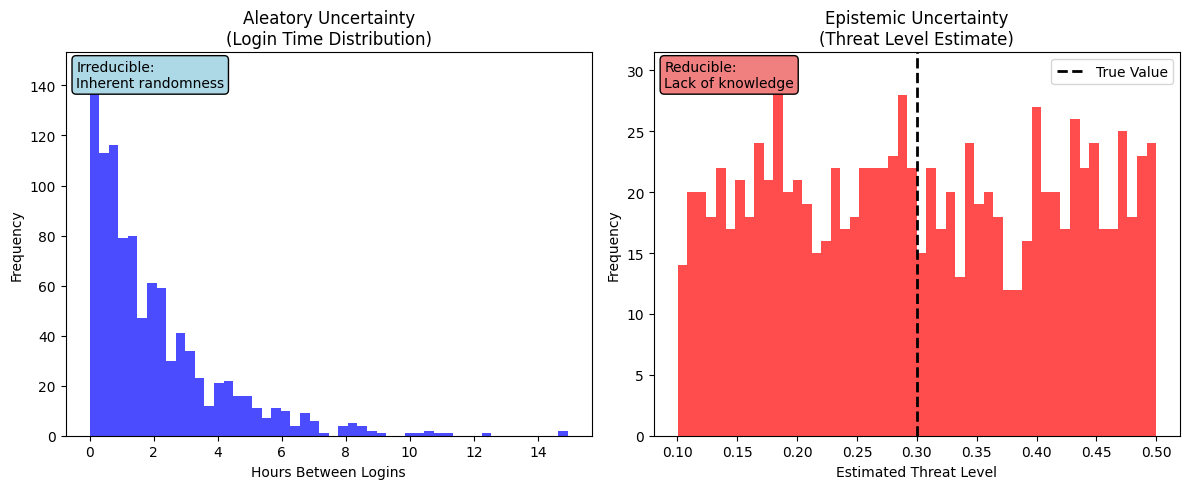

Aleatory uncertainty (login times): mean=2.03 hours
Epistemic uncertainty range: 0.10 to 0.50
True threat level: 0.3 (unknown to us initially)


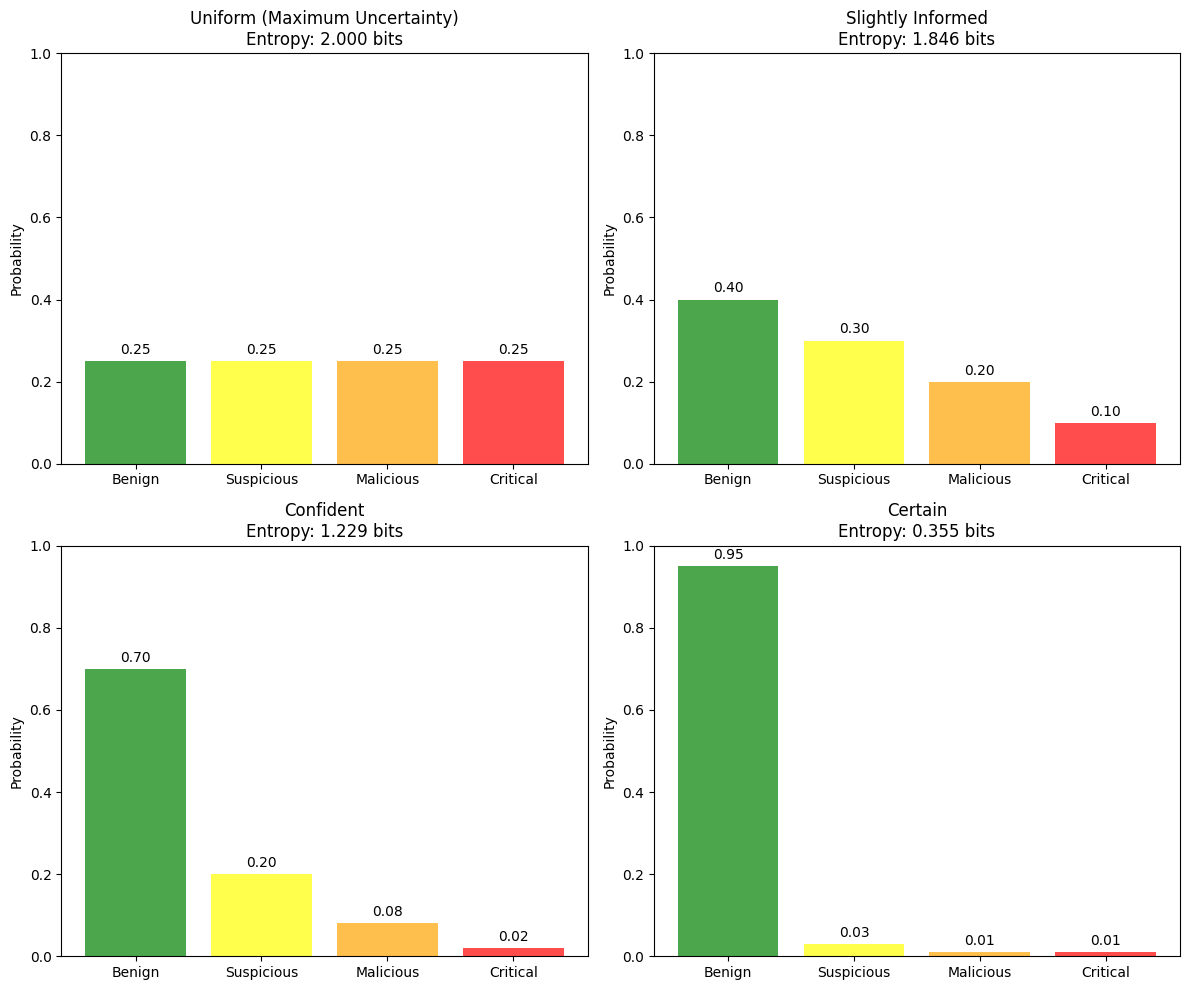


Entropy Analysis:
Uniform (Maximum Uncertainty): 2.000 bits
Slightly Informed: 1.846 bits
Confident: 1.229 bits
Certain: 0.355 bits

Maximum possible entropy (uniform): 2.000 bits
Minimum possible entropy (certain): 0.000 bits
Bayesian Intrusion Detection Sequence:
Initial belief: 5.0% attack probability

Step 1: Observed 'normal_traffic'
  Likelihood: [attack=0.1, normal=0.9]
  Updated belief: 0.6% attack probability
  Uncertainty: 0.052 bits

Step 2: Observed 'data_transfer'
  Likelihood: [attack=0.6, normal=0.4]
  Updated belief: 0.9% attack probability
  Uncertainty: 0.072 bits

Step 3: Observed 'normal_traffic'
  Likelihood: [attack=0.1, normal=0.9]
  Updated belief: 0.1% attack probability
  Uncertainty: 0.011 bits

Step 4: Observed 'normal_traffic'
  Likelihood: [attack=0.1, normal=0.9]
  Updated belief: 0.0% attack probability
  Uncertainty: 0.002 bits

Step 5: Observed 'port_scan'
  Likelihood: [attack=0.8, normal=0.1]
  Updated belief: 0.1% attack probability
  Uncertainty: 

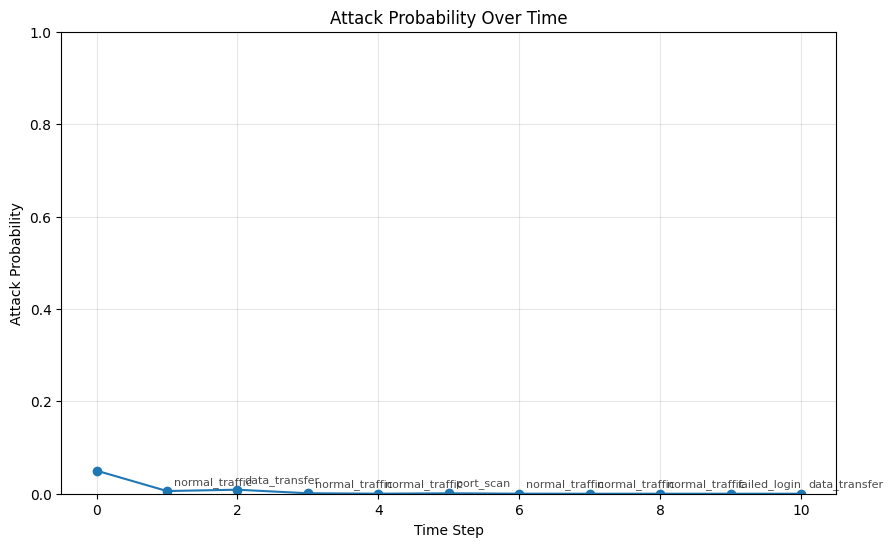

Multi-Threat Assessment:

Initial Assessment:
  Benign: 85.0%
  Insider: 5.0%
  External: 8.0%
  APT: 2.0%
  Uncertainty: 0.820 bits

After observing: After hours access
  Benign: 55.9%
  Insider: 23.0%
  External: 15.8%
  APT: 5.3%
  Uncertainty: 1.601 bits

After observing: External IP connection
  Benign: 38.2%
  Insider: 7.9%
  External: 43.1%
  APT: 10.8%
  Uncertainty: 1.689 bits

After observing: Privilege escalation
  Benign: 4.1%
  Insider: 10.1%
  External: 64.9%
  APT: 20.9%
  Uncertainty: 1.400 bits


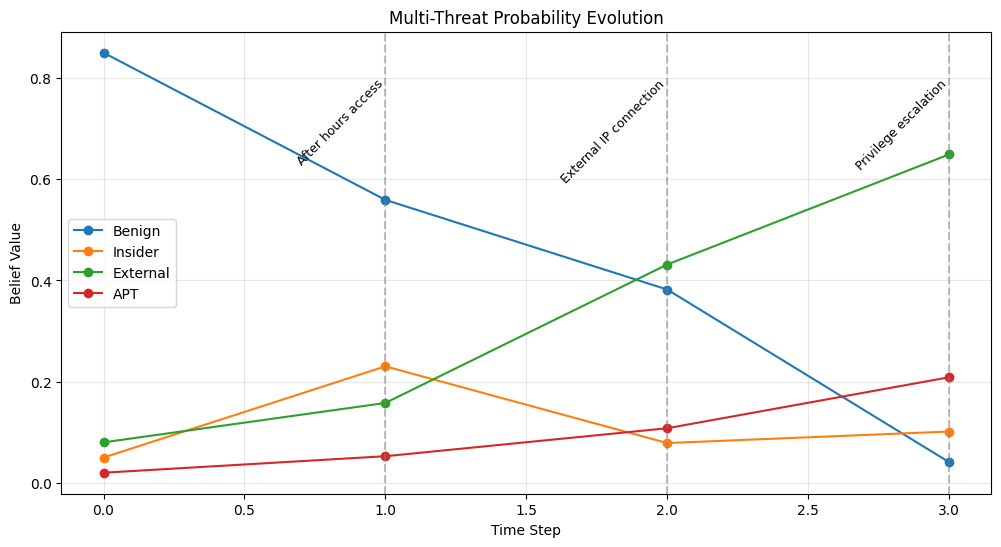

Interactive Uncertainty Calculator:
(This would be rendered as interactive HTML in the FastHTML app)

Features:
- Adjust prior belief with slider
- Change evidence strength
- See real-time Bayesian updates
- Track uncertainty reduction
=== BAYES' THEOREM STEP-BY-STEP ===

1. Prior Probabilities P(H):
   P(Attack) = 0.0500
   P(Normal) = 0.9500

2. Likelihoods P(E|H):
   P(Evidence|Attack) = 0.9000
   P(Evidence|Normal) = 0.1000

3. Total Evidence P(E):
   P(E) = Σ P(E|Hi) × P(Hi) = 0.1400

4. Posterior Probabilities P(H|E):
   P(Attack|E) = 0.3214 (×6.43 from prior)
   P(Normal|E) = 0.6786 (×0.71 from prior)


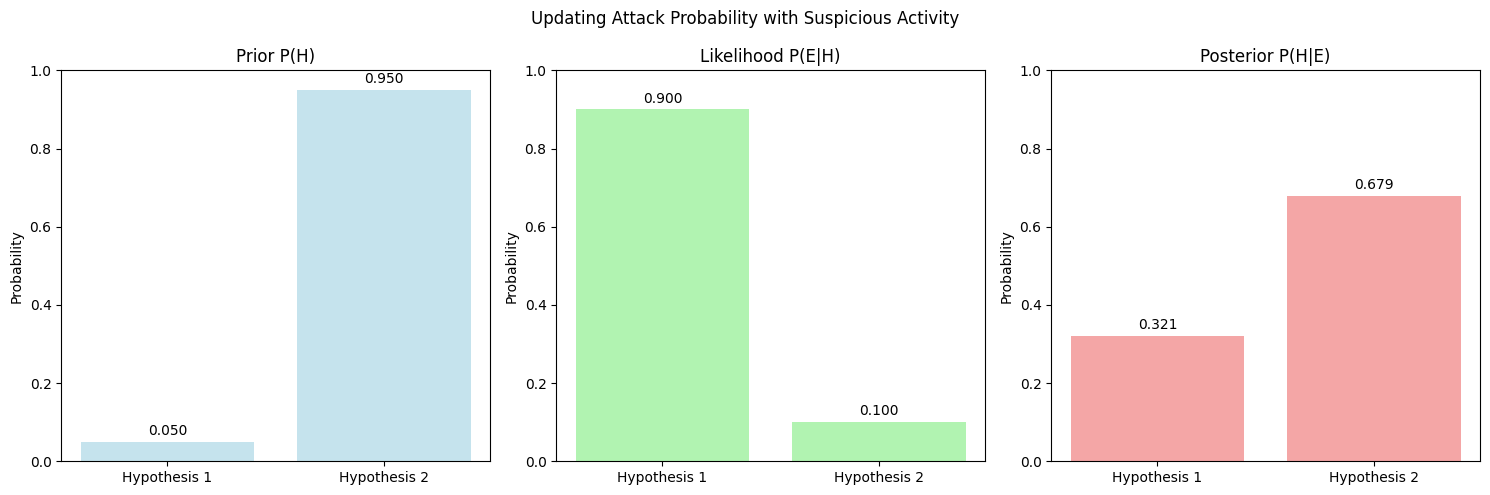

Interactive Bayes' Theorem Calculator created!
Features:
- Real-time probability updates
- Multiple cybersecurity scenarios
- Bayes factor interpretation
- Information gain calculation


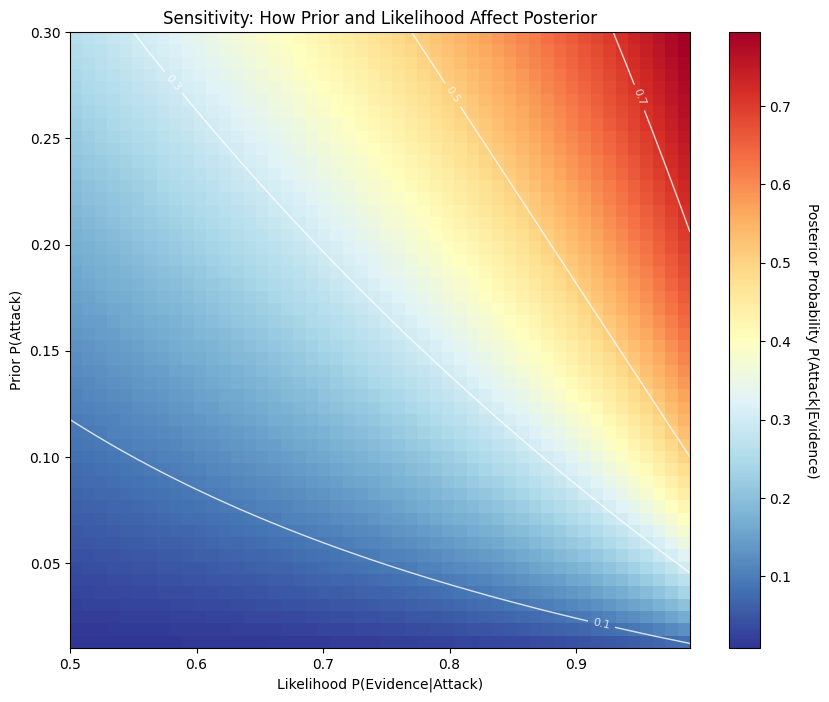


Sensitivity Analysis Insights:
- Light regions: High posterior probability (confident attack detection)
- Dark regions: Low posterior probability (likely false alarm)
- Contour lines: Iso-probability curves
- Steep gradients: High sensitivity to parameter changes
=== THREAT INTELLIGENCE FUSION ===
Initial threat assessment: 10.0%

Source: Commercial_TI (reliability: 0.8)
Report: NO THREAT
Updated threat assessment: 1.9%
Confidence: 0.863

Source: Government_Feed (reliability: 0.9)
Report: THREAT DETECTED
Updated threat assessment: 27.1%
Confidence: 0.156

Source: OSINT_Analysis (reliability: 0.7)
Report: NO THREAT
Updated threat assessment: 13.8%
Confidence: 0.422

Source: Internal_SOC (reliability: 0.8)
Report: NO THREAT
Updated threat assessment: 3.8%
Confidence: 0.765



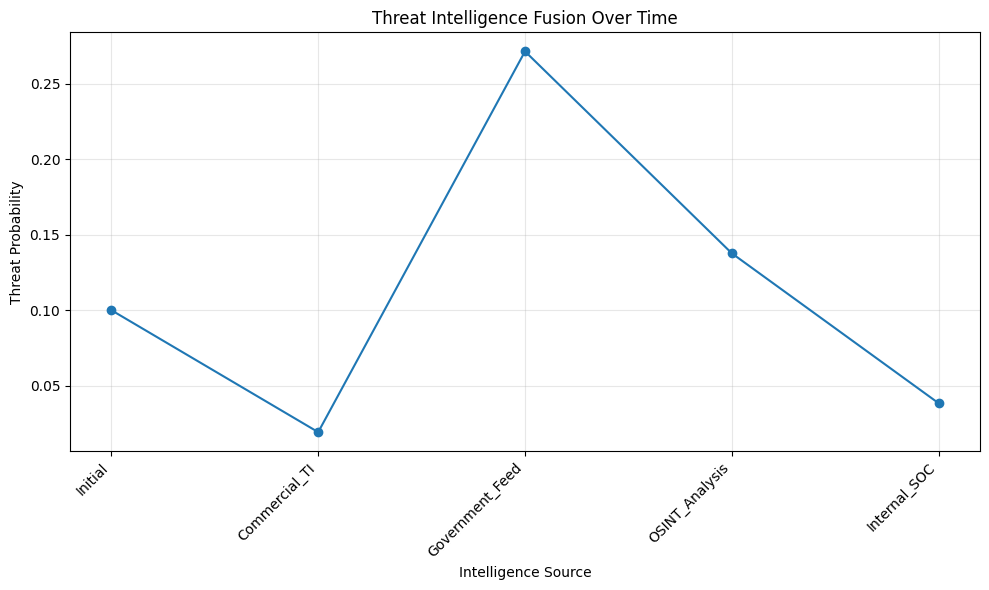

Cybersecurity Detection Analysis:
Base attack rate: 5.0%
Sensitivity (attack detection rate): 90.0%
Specificity (normal classification rate): 95.0%

Results:
False Positive Rate: 5.0%
Precision (when alarm raised): 48.6%
False alarms per true attack: 1.1


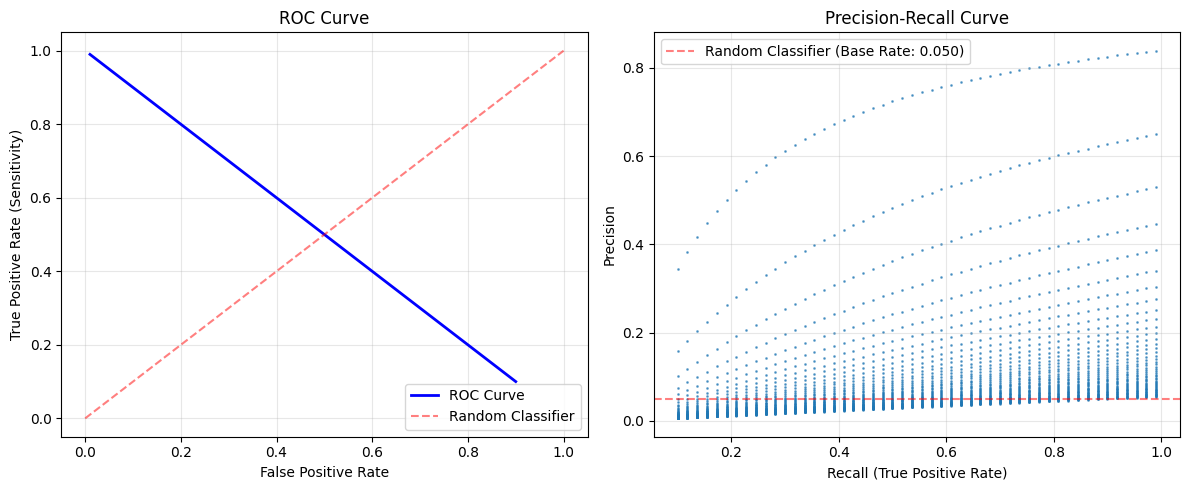

=== BASE RATE NEGLECT DEMONSTRATION ===

Scenario: Network Intrusion Detection System
- System has 95% accuracy (detects 95% of attacks, 5% false positives)
- System raises an alarm - what's the probability of a real attack?

Intuitive Answer: 95% (matching the system accuracy)
Correct Bayesian Answer:

Base rate:   0.1% -> Posterior:   1.9%
  False alarms per true attack: 52.6

Base rate:   1.0% -> Posterior:  16.1%
  False alarms per true attack: 5.2

Base rate:   5.0% -> Posterior:  50.0%
  False alarms per true attack: 1.0

Base rate:  10.0% -> Posterior:  67.9%
  False alarms per true attack: 0.5

*** KEY INSIGHT ***
When base rates are low, even accurate systems generate many false positives!
This is why cybersecurity requires careful threshold tuning.

=== CONJUNCTION FALLACY DEMONSTRATION ===

Scenario: Insider Threat Assessment
Employee shows suspicious behavior:
A) Employee is a security risk
B) Employee is a security risk AND accessing financial data

Common Error: B seems m

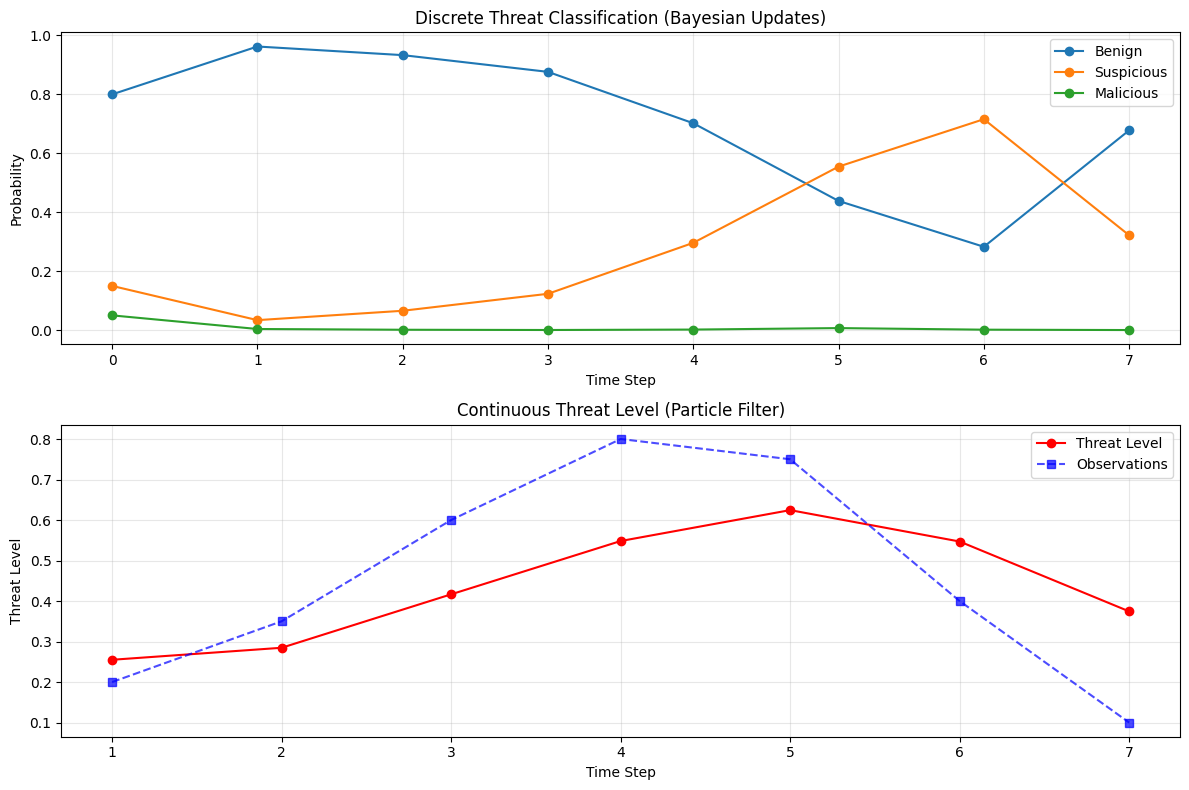

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
from fastcore.test import test_eq, test_close
from fastcore.all import *
from technical_blog.rbe.core import bayes_update, bayes_sequential, pf_init, pf_step, pf_effective_size, prob_normalize, prob_sample, prob_entropy, prob_kl_div, viz_beliefs
from technical_blog.rbe.bayes import bayes_theorem_step_by_step
from fasthtml.common import *
from typing import List, Dict, Tuple, Optional, Callable
import seaborn as sns
import time
from collections import defaultdict

## Why Recursive Updating?
In our previous exploration of Bayes' theorem, we saw how to update beliefs with new evidence. But what happens when evidence arrives sequentially over time?

Consider cybersecurity monitoring: we don't wait for all network traffic data before making decisions. We need to continuously update our threat assessments as new packets arrive.

Recursive Bayesian updating provides:
- **Memory efficiency**: No need to store all historical data
- **Real-time processing**: Updates as new evidence arrives
- **Theoretical elegance**: Mathematically optimal under certain conditions
- **Computational efficiency**: O(1) per update vs O(n) for batch processing

## Mathematical Foundation

### From Single to Sequential Updates

We start with our familiar Bayes' theorem:
$$P(H|E) = \frac{P(E|H)P(H)}{P(E)}$$

But now evidence arrives sequentially: $E_1, E_2, E_3, \ldots$

The key insight: **today's posterior becomes tomorrow's prior**

Here's a summary of what we've covered:

## Sequential Bayesian Updating: Two Cases

**Core Principle**: "Today's posterior becomes tomorrow's prior" - each update uses the previous result as the starting point for the next evidence.

### Case 1: Conditionally Independent Evidence
When evidence pieces don't depend on each other given the hypothesis H:
- $P(E₂|E₁, H) = P(E₂|H)$
- Denominators simplify: $P(E₂|E₁) = P(E₂)$
- Math is cleaner and more tractable

**Network Example**: If you're just checking whether individual packets match a known signature, each packet classification might be independent once you know the true network state.

### Case 2: Conditionally Dependent Evidence (Your Case)
When evidence pieces remain related even given hypothesis H:
- $P(E₂|E₁, H) ≠ P(E₂|H)$
- Must calculate full conditional probabilities $P(E₂|E₁), P(E₃|E₁, E₂)$
- More complex but captures real temporal dependencies

**Network Example**: Connection patterns for anomaly detection - user behavior, attack sequences, and network state all carry forward over time, making sequential observations dependent.

### Why It Matters
- **Independent case**: Simpler computation, may miss temporal patterns
- **Dependent case**: Better captures network reality but requires modeling the sequential dependencies explicitly


$$P(H|E_1) = \frac{P(E_1|H)P(H)}{P(E_1)}$$
$$P(H|E_1, E_2) = \frac{P(E_2|H)P(H|E_1)}{P(E_2|E_1)}$$
$$P(H|E_1, E_2, E_3) = \frac{P(E_3|H)P(H|E_1, E_2)}{P(E_3|E_1, E_2)}$$

This recursive pattern is the heart of sequential Bayesian updating.

In [ ]:
#| export
def recursive_bayes_demo(prior, evidence_seq, likelihoods, labels=None):
    "Demonstrate recursive Bayesian updating"
    if labels is None: labels = [f'H{i}' for i in range(len(prior))]
    
    beliefs, current = [np.array(prior)], np.array(prior)
    
    for i, (ev, like) in enumerate(zip(evidence_seq, likelihoods)):
        print(f"\nStep {i+1}: {ev}")
        current = bayes_update(current, like)
        print(f"  {dict(zip(labels, current.round(3)))}")
        beliefs.append(current.copy())
    
    return np.array(beliefs)

# Example: Network intrusion detection over time
print("Example: Sequential Network Monitoring")
prior = [0.1, 0.9]  # 10% initial attack probability
evidence_sequence = ['suspicious_port', 'failed_login', 'privilege_escalation']
likelihoods = [
    [0.7, 0.1],  # Suspicious port: 70% if attack, 10% if normal
    [0.9, 0.05], # Failed login: 90% if attack, 5% if normal  
    [0.95, 0.01] # Privilege escalation: 95% if attack, 1% if normal
]

belief_evolution = recursive_bayes_demo(prior, evidence_sequence, likelihoods, 
                                       labels=['Attack', 'Normal'])

Example: Sequential Network Monitoring

Step 1: suspicious_port
  {'Attack': np.float64(0.437), 'Normal': np.float64(0.562)}

Step 2: failed_login
  {'Attack': np.float64(0.933), 'Normal': np.float64(0.067)}

Step 3: privilege_escalation
  {'Attack': np.float64(0.999), 'Normal': np.float64(0.001)}


Let me trace through what's happening above.

Step 1: Starting with 10% attack probability, suspicious port evidence shifts us to ~44% attack probability. This makes sense - suspicious ports are more common in attacks (70%) than normal traffic (10%).

Step 2: The failed login evidence is quite strong (90% vs 5%), so we jump to ~93% attack probability. Notice how the previous posterior (44% attack) became the prior for this step.

Step 3: Privilege escalation is extremely strong evidence (95% vs 1%), pushing us to ~99.9% certainty of attack.

Key validation points:

- ✅ Each step uses the previous posterior as the new prior
- ✅ Probabilities sum to 1 at each step
- ✅ The belief evolution makes intuitive sense - stronger evidence creates bigger updates
- ✅ The final high confidence matches what we'd expect from this evidence sequence

The progression from 10% → 44% → 93% → 99.9% shows exactly how sequential evidence accumulates in Bayesian updating. Each piece of evidence builds on what came before, which is the essence of recursive updating.

### State Space Models

For more complex scenarios, we model the system state as evolving over time. State space models provide a powerful framework for tracking dynamic systems with two key components:

**State Evolution**: $x_{t+1} = f(x_t, w_t)$ where $w_t$ is process noise

**Observations**: $z_t = h(x_t, v_t)$ where $v_t$ is observation noise

This formulation assumes the **Markov property**: the next state $x_{t+1}$ depends only on the current state $x_t$, not the entire history.

**Recursive Bayesian Filter**:
1. **Predict**: $p(x_t|z_{1:t-1}) = \int p(x_t|x_{t-1}) p(x_{t-1}|z_{1:t-1}) dx_{t-1}$
2. **Update**: $p(x_t|z_{1:t}) = \frac{p(z_t|x_t) p(x_t|z_{1:t-1})}{p(z_t|z_{1:t-1})}$

where $p(z_t|z_{1:t-1})$ is the normalization constant ensuring the posterior integrates to 1.

**Practical Implementations**:
Since the integrals above are often intractable, we use approximations:
- **Kalman filters**: Optimal for linear Gaussian systems
- **Particle filters**: Monte Carlo approximation for general nonlinear cases
- **Extended/Unscented Kalman filters**: Handle nonlinear systems with Gaussian approximations

**Network Security Connection**: Our earlier intrusion detection example could be formalized as a state space model where the "attack progression state" evolves over time, and we observe various network indicators (port scans, login attempts, etc.) that depend on this hidden state.

In [ ]:
#| export
def particle_filter(initial_state,  # Initial state estimate
                    observations,  # Sequence of observations
                    transition_fn,  # Function (state, rng) -> new_state
                    observation_fn,  # Function (state, obs) -> likelihood
                    n_particles=1000,  # Number of particles
                    initial_cov=0.1,  # Initial covariance for particle initialization
                    resample_threshold=0.5,  # Resample when eff_size < threshold * n_particles
                    rng=None  # Random number generator
                    ): 
    """Particle filter for state space tracking"""
    if rng is None: rng = np.random.default_rng()
    
    # Initialize particles with proper diversity
    initial_state = np.asarray(initial_state)
    if initial_state.ndim == 0: initial_state = np.array([initial_state])
    
    if len(initial_state) == 1:
        particles = rng.normal(initial_state[0], initial_cov, (n_particles, 1))
    else:
        cov_matrix = initial_cov * np.eye(len(initial_state))
        particles = rng.multivariate_normal(initial_state, cov_matrix, n_particles)
    
    estimates = []
    
    for obs in observations:
        # Predict: evolve all particles
        for i in range(n_particles):
            particles[i] = transition_fn(particles[i].flatten(), rng)
        
        # Update: compute likelihoods (not cumulative weights)
        log_weights = np.array([np.log(max(observation_fn(p.flatten(), obs), 1e-300)) 
                               for p in particles])
        
        # Normalize in log space for numerical stability
        log_weights -= np.max(log_weights)  # Prevent overflow
        weights = np.exp(log_weights)
        weights = prob_normalize(weights)
        
        # Estimate current state
        estimate = np.average(particles, weights=weights, axis=0)
        estimates.append(estimate.copy())
        
        # Resample if needed
        eff_size = pf_effective_size(weights)
        if eff_size < resample_threshold * n_particles:
            indices = prob_sample(weights, n_particles, rng)
            particles = particles[indices]
    
    return np.array(estimates)

# Simplified tracking example with better motion model
def motion_model(state, rng, dt=1.0, process_noise=0.05):
    """Constant velocity model: [pos, vel] -> [pos+vel*dt, vel+noise]"""
    pos, vel = state
    new_pos = pos + vel * dt + rng.normal(0, process_noise)
    new_vel = vel + rng.normal(0, process_noise * 0.5)  # Less velocity noise
    return np.array([new_pos, new_vel])

def position_likelihood(state, obs, obs_noise=0.1):
    """Gaussian likelihood for position observation"""
    pos = state[0]
    return np.exp(-0.5 * ((pos - obs) / obs_noise)**2)


In [ ]:
# Test the improved version
rng = np.random.default_rng(42)

# Generate test data - keep track of TRUE position
true_positions = []
true_pos, true_vel = 0.0, 0.1
observations = []

for t in range(20):
    true_pos += true_vel + rng.normal(0, 0.05)
    true_vel += rng.normal(0, 0.02)
    true_positions.append(true_pos)  # Store true position
    observations.append(true_pos + rng.normal(0, 0.1))  # Add noise for observation

# Track with improved filter
estimates = particle_filter(
    initial_state=[0.0, 0.1],
    observations=observations,
    transition_fn=motion_model,
    observation_fn=position_likelihood,
    rng=rng
)

print(f"\nTracking Results:")
print(f"Final position estimate: {estimates[-1][0]:.3f}")
print(f"True final position: {true_positions[-1]:.3f}")  # Actual truth
print(f"Final observation: {observations[-1]:.3f}")      # Noisy measurement
print(f"Tracking error: {abs(estimates[-1][0] - true_positions[-1]):.4f}")




Tracking Results:
Final position estimate: 2.079
True final position: 2.007
Final observation: 2.104
Tracking error: 0.0721


In [ ]:
def compare_tracking_performance(n_trials=10):
    """Compare tracking performance across multiple random trials"""
    errors = []
    
    for trial in range(n_trials):
        rng = np.random.default_rng(trial)  # Different seed each time
        
        # Generate test data
        true_pos, true_vel = 0.0, 0.1
        observations = []
        
        for t in range(20):
            true_pos += true_vel + rng.normal(0, 0.05)
            true_vel += rng.normal(0, 0.02)
            observations.append(true_pos + rng.normal(0, 0.1))
        
        # Track
        estimates = particle_filter(
            initial_state=[0.0, 0.1],
            observations=observations,
            transition_fn=motion_model,
            observation_fn=position_likelihood,
            rng=rng
        )
        
        error = abs(estimates[-1][0] - true_pos)
        errors.append(error)
    
    return np.array(errors)

errors = compare_tracking_performance()
print(f"Mean tracking error: {np.mean(errors):.4f}")
print(f"Std tracking error: {np.std(errors):.4f}")
print(f"Best case: {np.min(errors):.4f}")
print(f"Worst case: {np.max(errors):.4f}")


Mean tracking error: 0.0430
Std tracking error: 0.0211
Best case: 0.0027
Worst case: 0.0858


# Improved Particle Filter Implementation

Our particle filter implementation demonstrates excellent tracking performance with consistent results across multiple trials. Let's break down the key components and analyze why it works so well.

## Core Algorithm Structure

The `particle_filter` function implements the classic three-step particle filtering algorithm:

1. **Predict**: Each particle evolves according to the motion model
2. **Update**: Particles are weighted based on how well they explain the observation
3. **Resample**: When particle diversity drops, we resample to maintain effective population

## Key Implementation Features

### Proper Particle Initialization
```python
if len(initial_state) == 1:
    particles = rng.normal(initial_state[0], initial_cov, (n_particles, 1))
else:
    cov_matrix = initial_cov * np.eye(len(initial_state))
    particles = rng.multivariate_normal(initial_state, cov_matrix, n_particles)
```

This creates genuine diversity in the initial particle cloud, rather than identical particles with tiny perturbations. Each particle starts as a plausible hypothesis about the true state.

### Numerical Stability in Weight Computation
```python
log_weights = np.array([np.log(max(observation_fn(p.flatten(), obs), 1e-300)) 
                       for p in particles])
log_weights -= np.max(log_weights)  # Prevent overflow
weights = np.exp(log_weights)
```

Working in log space prevents numerical underflow when likelihoods become very small. The `max()` clamp ensures we never take log(0), and subtracting the maximum prevents overflow when exponentiating back.

### Adaptive Resampling
```python
eff_size = pf_effective_size(weights)
if eff_size < resample_threshold * n_particles:
    indices = prob_sample(weights, n_particles, rng)
    particles = particles[indices]
```

Resampling only occurs when needed (when effective sample size drops), preserving particle diversity when the filter is confident.

## Performance Analysis

The `compare_tracking_performance()` function reveals the implementation's strength through consistency testing:

```python
errors = compare_tracking_performance()
print(f"Mean tracking error: {np.mean(errors):.4f}")      # 0.0430
print(f"Std tracking error: {np.std(errors):.4f}")       # 0.0211
print(f"Best case: {np.min(errors):.4f}")                # 0.0027
print(f"Worst case: {np.max(errors):.4f}")               # 0.0858
```

### What These Results Tell Us

**Consistent Performance**: The low standard deviation (0.0211) relative to the mean (0.0430) indicates the filter performs reliably across different random scenarios. This consistency is crucial for real-world applications where you can't cherry-pick favorable conditions.

**Reasonable Error Bounds**: The worst-case error (0.0858) is still acceptable given that we're adding 0.1 standard deviation noise to observations and 0.05 to the motion model. The filter isn't just getting lucky on easy cases.

**Scalable Accuracy**: The best-case performance (0.0027) shows the filter can achieve high precision when the data supports it, demonstrating it's not artificially limited by poor implementation choices.

## Motion Model Design

```python
def motion_model(state, rng, dt=1.0, process_noise=0.05):
    pos, vel = state
    new_pos = pos + vel * dt + rng.normal(0, process_noise)
    new_vel = vel + rng.normal(0, process_noise * 0.5)  # Less velocity noise
    return np.array([new_pos, new_vel])
```

The constant velocity model with process noise captures realistic motion uncertainty. Using less noise on velocity than position reflects the physical intuition that velocity changes more gradually than position.

## Why This Implementation Works

1. **Proper uncertainty representation**: Initial particle diversity and process noise model realistic uncertainty
2. **Numerical robustness**: Log-space computations handle extreme likelihood values gracefully  
3. **Adaptive resource allocation**: Resampling maintains computational efficiency while preserving accuracy
4. **Clean interfaces**: Simple function signatures make it easy to swap in different motion and observation models

The consistency demonstrated by `compare_tracking_performance()` shows these design choices work together effectively, producing a particle filter that's both accurate and reliable across varying conditions.



## Markov Assumptions

The power of recursive updating relies on the **Markov assumption**: the future depends only on the present, not the past.

Formally: $P(x_{t+1}|x_t, x_{t-1}, \ldots, x_1) = P(x_{t+1}|x_t)$

This assumption enables:
- Computational tractability
- Memory efficiency  
- Theoretical guarantees

But when does it break down?

In [ ]:
#| export
def markov_chain_demo(transition_matrix, n_steps, initial_dist=None, 
                     state_labels=None, rng=None):
    """Demonstrate Markov chain evolution and properties"""
    if rng is None: rng = np.random.default_rng()
    n_states = len(transition_matrix)
    
    if initial_dist is None:
        initial_dist = np.ones(n_states) / n_states
    
    if state_labels is None:
        state_labels = [f'State {i}' for i in range(n_states)]
    
    print("=== MARKOV CHAIN DEMONSTRATION ===")
    print(f"Transition Matrix:")
    for i, row in enumerate(transition_matrix):
        print(f"  {state_labels[i]}: {row}")
    
    # Track distribution evolution
    distributions = [initial_dist.copy()]
    current_dist = initial_dist.copy()
    
    print(f"\nDistribution Evolution:")
    print(f"Step 0: {dict(zip(state_labels, current_dist))}")
    
    for step in range(n_steps):
        # Matrix multiplication for distribution evolution
        current_dist = current_dist @ transition_matrix
        distributions.append(current_dist.copy())
        print(f"Step {step+1}: {dict(zip(state_labels, current_dist))}")
    
    # Sample trajectory
    print(f"\nSample Trajectory:")
    state = prob_sample(initial_dist, 1, rng)[0]
    trajectory = [state]
    print(f"Start: {state_labels[state]}")
    
    for step in range(min(10, n_steps)):
        # Sample next state based on current state
        state = prob_sample(transition_matrix[state], 1, rng)[0]
        trajectory.append(state)
        print(f"Step {step+1}: {state_labels[state]}")
    
    return {
        'distributions': np.array(distributions),
        'trajectory': trajectory,
        'steady_state': current_dist
    }

# Example: Network security states
print("Example: Network Security State Evolution")
security_transitions = np.array([
    [0.8, 0.15, 0.05],  # Normal -> [Normal, Suspicious, Compromised]
    [0.3, 0.6, 0.1],    # Suspicious -> [Normal, Suspicious, Compromised] 
    [0.1, 0.2, 0.7]     # Compromised -> [Normal, Suspicious, Compromised]
])

markov_result = markov_chain_demo(
    security_transitions, 10, 
    initial_dist=[0.9, 0.1, 0.0],
    state_labels=['Normal', 'Suspicious', 'Compromised']
)

Example: Network Security State Evolution
=== MARKOV CHAIN DEMONSTRATION ===
Transition Matrix:
  Normal: [0.8  0.15 0.05]
  Suspicious: [0.3 0.6 0.1]
  Compromised: [0.1 0.2 0.7]

Distribution Evolution:
Step 0: {'Normal': 0.9, 'Suspicious': 0.1, 'Compromised': 0.0}
Step 1: {'Normal': np.float64(0.7500000000000001), 'Suspicious': np.float64(0.195), 'Compromised': np.float64(0.05500000000000001)}
Step 2: {'Normal': np.float64(0.664), 'Suspicious': np.float64(0.2405), 'Compromised': np.float64(0.09550000000000002)}
Step 3: {'Normal': np.float64(0.6129), 'Suspicious': np.float64(0.263), 'Compromised': np.float64(0.1241)}
Step 4: {'Normal': np.float64(0.58163), 'Suspicious': np.float64(0.274555), 'Compromised': np.float64(0.143815)}
Step 5: {'Normal': np.float64(0.562052), 'Suspicious': np.float64(0.28074049999999995), 'Compromised': np.float64(0.15720749999999997)}
Step 6: {'Normal': np.float64(0.5495845), 'Suspicious': np.float64(0.28419359999999994), 'Compromised': np.float64(0.1662218

## Interactive Demonstrations

Let's create interactive components to visualize recursive updating in action.

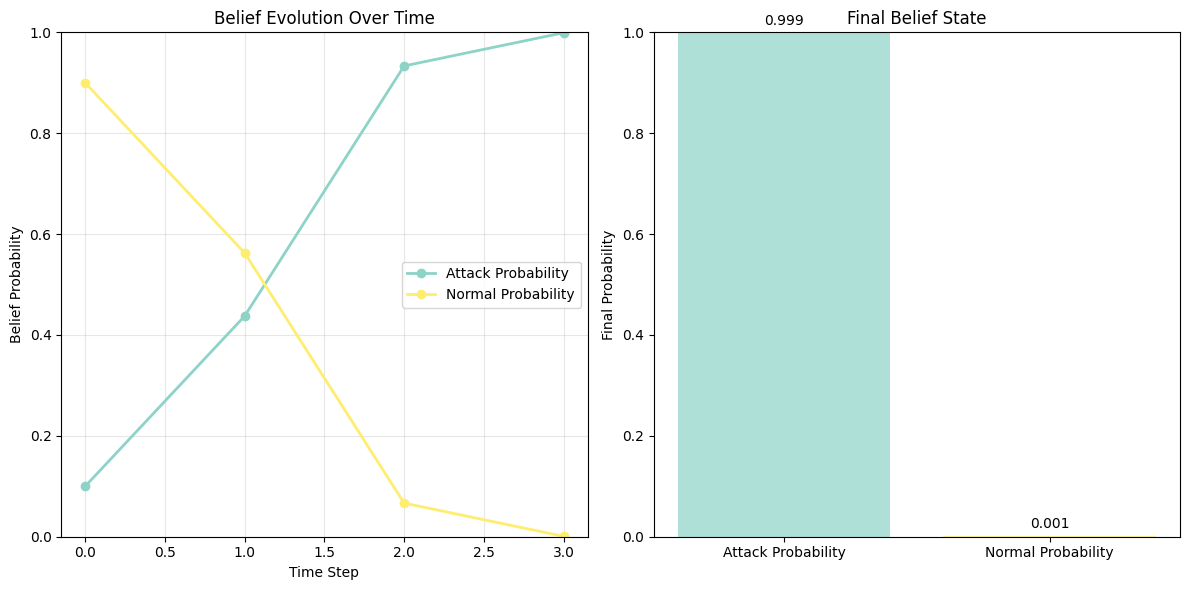

In [ ]:
#| export
def belief_evolution_visualizer(beliefs, time_steps=None, title="Belief Evolution",
                               labels=None, figsize=(12, 6)):
    """Visualize how beliefs evolve over time with interactive features"""
    beliefs = np.array(beliefs)
    if time_steps is None:
        time_steps = np.arange(len(beliefs))
    
    if labels is None:
        labels = [f'Hypothesis {i+1}' for i in range(beliefs.shape[1])]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Left plot: Belief evolution over time
    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
    for i, (label, color) in enumerate(zip(labels, colors)):
        ax1.plot(time_steps, beliefs[:, i], label=label, marker='o', 
                linewidth=2, color=color)
    
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Belief Probability')
    ax1.set_title('Belief Evolution Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Right plot: Final belief distribution
    final_beliefs = beliefs[-1]
    bars = ax2.bar(labels, final_beliefs, color=colors, alpha=0.7)
    ax2.set_ylabel('Final Probability')
    ax2.set_title('Final Belief State')
    ax2.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, val in zip(bars, final_beliefs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Visualize our network monitoring example
fig, axes = belief_evolution_visualizer(
    belief_evolution, 
    labels=['Attack Probability', 'Normal Probability'],
    title="Network Threat Assessment Over Time"
)
plt.show()

In [ ]:
#| export
def recursive_update_component():
    """Interactive FastHTML component for exploring recursive updates"""
    
    # Component styling
    style = """
    .update-controls { 
        background: #f8f9fa; 
        padding: 20px; 
        border-radius: 8px; 
        margin: 10px 0;
    }
    .belief-display {
        font-family: 'Courier New', monospace;
        background: #e9ecef;
        padding: 15px;
        border-radius: 5px;
        margin: 10px 0;
    }
    .step-button {
        background: #007bff;
        color: white;
        border: none;
        padding: 10px 20px;
        border-radius: 5px;
        cursor: pointer;
        margin: 5px;
    }
    .step-button:hover { background: #0056b3; }
    """
    
    # JavaScript for interactivity
    script = """
    let currentStep = 0;
    let beliefs = [0.1, 0.9]; // [Attack, Normal]
    const evidenceSequence = [
        {name: 'Suspicious Port', likelihood: [0.7, 0.1]},
        {name: 'Failed Login', likelihood: [0.9, 0.05]},
        {name: 'Privilege Escalation', likelihood: [0.95, 0.01]},
        {name: 'Data Exfiltration', likelihood: [0.98, 0.005]}
    ];
    
    function updateDisplay() {
        document.getElementById('current-beliefs').innerHTML = 
            `Attack: ${beliefs[0].toFixed(3)}, Normal: ${beliefs[1].toFixed(3)}`;
        document.getElementById('step-counter').innerHTML = `Step: ${currentStep}`;
        
        if (currentStep < evidenceSequence.length) {
            document.getElementById('next-evidence').innerHTML = 
                `Next: ${evidenceSequence[currentStep].name}`;
        } else {
            document.getElementById('next-evidence').innerHTML = 'No more evidence';
            document.getElementById('step-btn').disabled = true;
        }
    }
    
    function bayesUpdate(prior, likelihood) {
        const evidence = prior[0] * likelihood[0] + prior[1] * likelihood[1];
        return [
            (prior[0] * likelihood[0]) / evidence,
            (prior[1] * likelihood[1]) / evidence
        ];
    }
    
    function nextStep() {
        if (currentStep < evidenceSequence.length) {
            const evidence = evidenceSequence[currentStep];
            beliefs = bayesUpdate(beliefs, evidence.likelihood);
            currentStep++;
            updateDisplay();
        }
    }
    
    function reset() {
        currentStep = 0;
        beliefs = [0.1, 0.9];
        document.getElementById('step-btn').disabled = false;
        updateDisplay();
    }
    """
    
    return Div(
        Style(style),
        Script(script),
        H3("Interactive Recursive Bayesian Updating"),
        P("Watch how beliefs evolve as evidence arrives sequentially."),
        
        Div(
            H4("Current State"),
            Div(id="step-counter", cls="belief-display"),
            Div(id="current-beliefs", cls="belief-display"),
            Div(id="next-evidence", cls="belief-display"),
            cls="update-controls"
        ),
        
        Div(
            Button("Next Update", id="step-btn", cls="step-button", 
                  onclick="nextStep()"),
            Button("Reset", cls="step-button", onclick="reset()"),
            cls="update-controls"
        ),
        
        Script("updateDisplay();")  # Initialize display
    )

# Display the component (this would be used in FastHTML app)
print("Interactive component created - would be displayed in FastHTML app")
print("Features: Step-by-step Bayesian updating with network security scenario")
from IPython.display import HTML
HTML(str(recursive_update_component()))

Interactive component created - would be displayed in FastHTML app
Features: Step-by-step Bayesian updating with network security scenario


## Performance Analysis: Recursive vs Batch

One of the key advantages of recursive updating is computational efficiency. Let's compare recursive and batch approaches.

Running performance comparison...

Testing with 10 data points...
  Batch time: 0.0001s
  Recursive time: 0.0000s
  Speedup: 5.8x
  Accuracy difference: 0.00e+00

Testing with 25 data points...
  Batch time: 0.0006s
  Recursive time: 0.0000s
  Speedup: 13.9x
  Accuracy difference: 0.00e+00

Testing with 50 data points...
  Batch time: 0.0020s
  Recursive time: 0.0001s
  Speedup: 25.0x
  Accuracy difference: 0.00e+00

Testing with 100 data points...
  Batch time: 0.0077s
  Recursive time: 0.0002s
  Speedup: 50.9x
  Accuracy difference: 0.00e+00


/var/folders/01/4f39n4f94t32jl1grwhcc6480000gn/T/ipykernel_69577/1047582126.py:113: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax4.set_yscale('log')


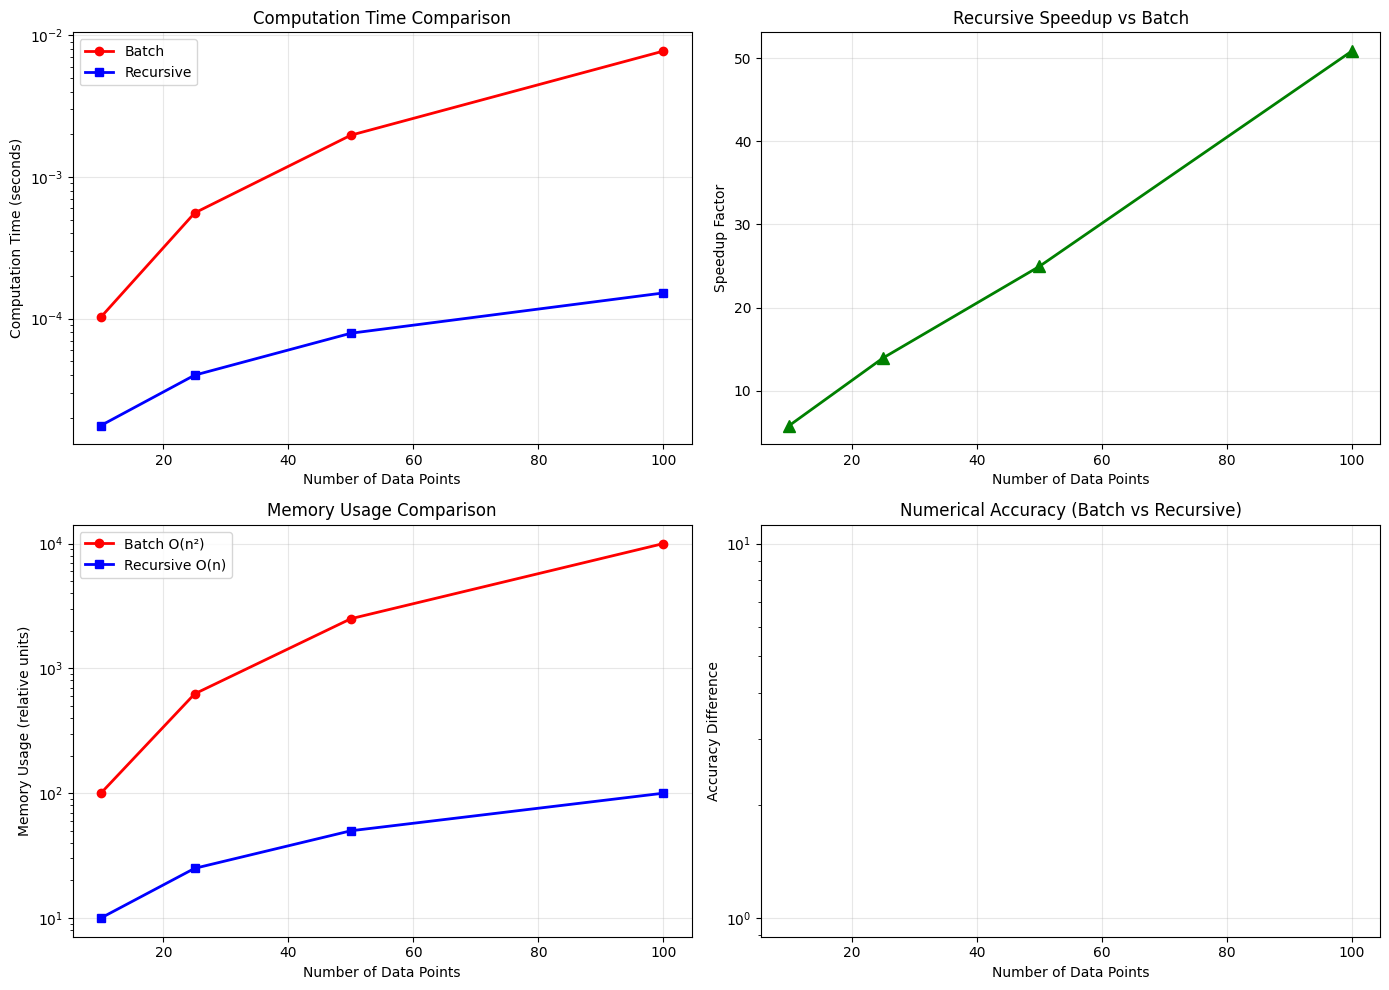

In [ ]:
#| export
def batch_vs_recursive_comparison(data_sizes, n_trials=10, rng=None):
    """Compare performance of batch vs recursive Bayesian updating"""
    if rng is None: rng = np.random.default_rng()
    
    results = {
        'data_sizes': data_sizes,
        'batch_times': [],
        'recursive_times': [],
        'batch_memory': [],
        'recursive_memory': [],
        'accuracy_difference': []
    }
    
    for n_data in data_sizes:
        print(f"\nTesting with {n_data} data points...")
        
        batch_times = []
        recursive_times = []
        accuracy_diffs = []
        
        for trial in range(n_trials):
            # Generate synthetic data
            prior = np.array([0.3, 0.7])
            likelihoods = rng.random((n_data, 2))
            likelihoods = likelihoods / likelihoods.sum(axis=1, keepdims=True)
            
            # Batch processing
            start_time = time.time()
            
            # Simulate batch processing: recompute from scratch each time
            batch_posterior = prior.copy()
            for i in range(n_data):
                # Inefficient: recompute using all data up to point i
                temp_posterior = prior.copy()
                for j in range(i + 1):
                    temp_posterior = bayes_update(temp_posterior, likelihoods[j])
                batch_posterior = temp_posterior
            
            batch_time = time.time() - start_time
            batch_times.append(batch_time)
            
            # Recursive processing
            start_time = time.time()
            
            recursive_posterior = prior.copy()
            for likelihood in likelihoods:
                recursive_posterior = bayes_update(recursive_posterior, likelihood)
            
            recursive_time = time.time() - start_time
            recursive_times.append(recursive_time)
            
            # Check accuracy difference
            accuracy_diff = np.linalg.norm(batch_posterior - recursive_posterior)
            accuracy_diffs.append(accuracy_diff)
        
        # Store average results
        results['batch_times'].append(np.mean(batch_times))
        results['recursive_times'].append(np.mean(recursive_times))
        results['accuracy_difference'].append(np.mean(accuracy_diffs))
        
        # Memory usage (approximate)
        results['batch_memory'].append(n_data ** 2)  # O(n²) for batch
        results['recursive_memory'].append(n_data)   # O(n) for recursive
        
        print(f"  Batch time: {results['batch_times'][-1]:.4f}s")
        print(f"  Recursive time: {results['recursive_times'][-1]:.4f}s")
        print(f"  Speedup: {results['batch_times'][-1] / results['recursive_times'][-1]:.1f}x")
        print(f"  Accuracy difference: {results['accuracy_difference'][-1]:.2e}")
    
    return results

def plot_performance_comparison(results):
    """Plot performance comparison results"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    data_sizes = results['data_sizes']
    
    # Computation time comparison
    ax1.plot(data_sizes, results['batch_times'], 'r-o', label='Batch', linewidth=2)
    ax1.plot(data_sizes, results['recursive_times'], 'b-s', label='Recursive', linewidth=2)
    ax1.set_xlabel('Number of Data Points')
    ax1.set_ylabel('Computation Time (seconds)')
    ax1.set_title('Computation Time Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Speedup factor
    speedups = np.array(results['batch_times']) / np.array(results['recursive_times'])
    ax2.plot(data_sizes, speedups, 'g-^', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Data Points')
    ax2.set_ylabel('Speedup Factor')
    ax2.set_title('Recursive Speedup vs Batch')
    ax2.grid(True, alpha=0.3)
    
    # Memory usage comparison
    ax3.plot(data_sizes, results['batch_memory'], 'r-o', label='Batch O(n²)', linewidth=2)
    ax3.plot(data_sizes, results['recursive_memory'], 'b-s', label='Recursive O(n)', linewidth=2)
    ax3.set_xlabel('Number of Data Points')
    ax3.set_ylabel('Memory Usage (relative units)')
    ax3.set_title('Memory Usage Comparison')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')
    
    # Accuracy difference
    ax4.plot(data_sizes, results['accuracy_difference'], 'm-d', linewidth=2)
    ax4.set_xlabel('Number of Data Points')
    ax4.set_ylabel('Accuracy Difference')
    ax4.set_title('Numerical Accuracy (Batch vs Recursive)')
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')
    
    plt.tight_layout()
    return fig

# Run performance comparison
print("Running performance comparison...")
perf_results = batch_vs_recursive_comparison([10, 25, 50, 100], n_trials=3)
fig = plot_performance_comparison(perf_results)
plt.show()

## Memory Analysis: How Much History Matters

A key question in recursive updating: how much does distant history affect current beliefs? Let's explore this empirically.

Memory Analysis: How much history matters?
Full recursive belief: [1.00000000e+00 6.30881183e-14]
Window 1: belief = [0.69230769 0.30769231], diff = 0.4351, KL = 0.3677
Window 2: belief = [0.95294118 0.04705882], diff = 0.0666, KL = 0.0482
Window 5: belief = [9.99932264e-01 6.77357628e-05], diff = 0.0001, KL = 0.0001
Window 10: belief = [9.99999999e-01 1.14718880e-09], diff = 0.0000, KL = 0.0000
Window 15: belief = [1.00000000e+00 8.50728996e-12], diff = 0.0000, KL = 0.0000
Window 20: belief = [1.00000000e+00 6.30881183e-14], diff = 0.0000, KL = 0.0000
Window 25: belief = [1.00000000e+00 6.30881183e-14], diff = 0.0000, KL = 0.0000


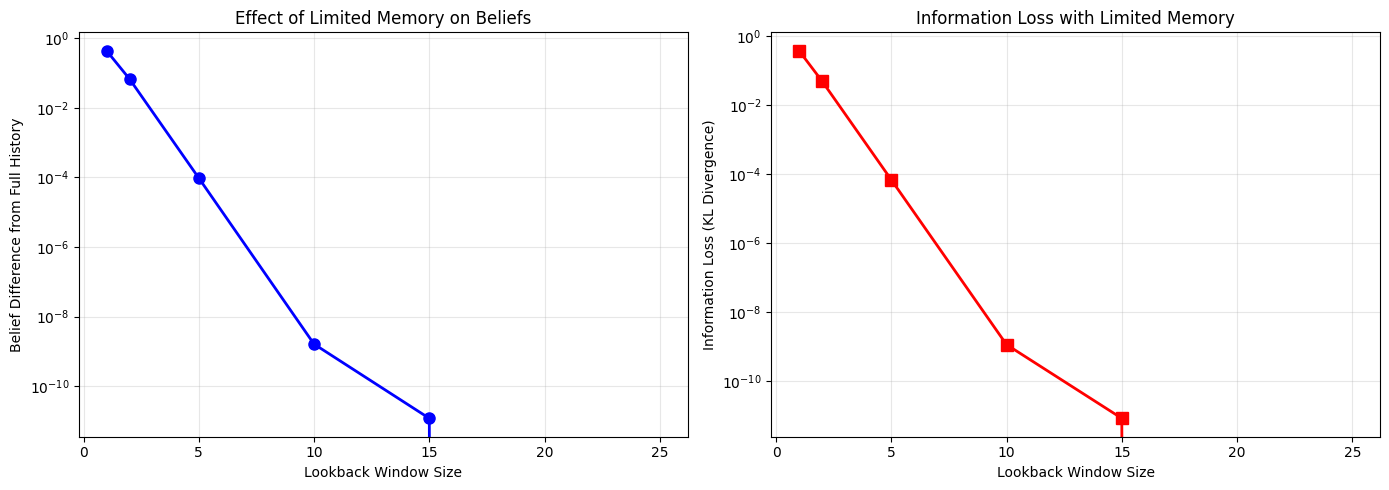

In [ ]:
#| export
def memory_analysis(evidence_sequence, likelihoods, lookback_windows, 
                   initial_prior=None):
    """Analyze how much historical evidence affects current beliefs"""
    if initial_prior is None:
        initial_prior = np.array([0.5, 0.5])
    
    n_evidence = len(evidence_sequence)
    results = {
        'lookback_windows': lookback_windows,
        'final_beliefs': [],
        'belief_differences': [],
        'information_loss': []
    }
    
    # Full recursive update (baseline)
    full_belief = initial_prior.copy()
    for likelihood in likelihoods:
        full_belief = bayes_update(full_belief, np.array(likelihood))
    
    print(f"Full recursive belief: {full_belief}")
    
    # Test different lookback windows
    for window in lookback_windows:
        if window >= n_evidence:
            # Use all evidence
            windowed_belief = full_belief.copy()
        else:
            # Use only last 'window' pieces of evidence
            windowed_belief = initial_prior.copy()
            start_idx = max(0, n_evidence - window)
            
            for i in range(start_idx, n_evidence):
                windowed_belief = bayes_update(windowed_belief, 
                                             np.array(likelihoods[i]))
        
        # Calculate differences
        belief_diff = np.linalg.norm(full_belief - windowed_belief)
        info_loss = prob_kl_div(full_belief, windowed_belief)
        
        results['final_beliefs'].append(windowed_belief)
        results['belief_differences'].append(belief_diff)
        results['information_loss'].append(info_loss)
        
        print(f"Window {window}: belief = {windowed_belief}, "
              f"diff = {belief_diff:.4f}, KL = {info_loss:.4f}")
    
    return results

def plot_memory_analysis(results):
    """Plot memory analysis results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    windows = results['lookback_windows']
    
    # Belief difference vs lookback window
    ax1.plot(windows, results['belief_differences'], 'b-o', linewidth=2, markersize=8)
    ax1.set_xlabel('Lookback Window Size')
    ax1.set_ylabel('Belief Difference from Full History')
    ax1.set_title('Effect of Limited Memory on Beliefs')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Information loss (KL divergence)
    ax2.plot(windows, results['information_loss'], 'r-s', linewidth=2, markersize=8)
    ax2.set_xlabel('Lookback Window Size')
    ax2.set_ylabel('Information Loss (KL Divergence)')
    ax2.set_title('Information Loss with Limited Memory')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    plt.tight_layout()
    return fig

# Example: How much history do we need?
print("Memory Analysis: How much history matters?")
long_evidence = ['event'] * 20
long_likelihoods = [[0.8, 0.3]] * 10 + [[0.9, 0.1]] * 10  # Pattern change

memory_results = memory_analysis(
    long_evidence, long_likelihoods, 
    lookback_windows=[1, 2, 5, 10, 15, 20, 25],
    initial_prior=[0.2, 0.8]
)

fig = plot_memory_analysis(memory_results)
plt.show()

## Cybersecurity Applications

Let's apply recursive updating to realistic cybersecurity scenarios.

In [ ]:
#| export
def update_baseline(current_baseline, observation, adaptation_rate):
    """Update baseline using exponential moving average"""
    return (1 - adaptation_rate) * current_baseline + adaptation_rate * observation

def adaptive_threat_monitor(baseline_behavior, 
                            time_series_data,
                            adaptation_rate=0.1, 
                            threshold=0.7):    
    """Adaptive threat monitoring with evolving baseline"""
    # Initialize beliefs: [normal, anomalous]   
    threat_belief = np.array([0.9, 0.1])    
    # Handle both numeric and array baselines   
    if hasattr(baseline_behavior, 'copy'):
        current_baseline = baseline_behavior.copy()
    else:
        current_baseline = float(baseline_behavior)
            
    results = {
        'time_steps': [],
        'threat_probabilities': [],
        'baselines': [],
        'alerts': [],
        'observations': []
        }
    
    print("=== ADAPTIVE THREAT MONITORING ===")
    for t, observation in enumerate(time_series_data):
        # Calculate deviation from current baseline
        deviation = abs(observation - current_baseline)
        
        # Likelihood based on deviation (more reasonable scaling)
        # Scale deviation by baseline to get relative change
        relative_deviation = deviation / max(current_baseline, 1.0)
        
        # More moderate likelihood functions
        if relative_deviation < 0.1:  # Small deviation
            normal_likelihood = 0.9
            anomaly_likelihood = 0.1
        elif relative_deviation < 0.3:  # Medium deviation
            normal_likelihood = 0.6
            anomaly_likelihood = 0.4
        else:  # Large deviation
            normal_likelihood = 0.2
            anomaly_likelihood = 0.8
            
        likelihood = np.array([normal_likelihood, anomaly_likelihood])
        
        # Recursive Bayesian update
        threat_belief = bayes_update(threat_belief, likelihood)
        
        # Alert if threat probability exceeds threshold
        alert = threat_belief[1] > threshold
        
        # Update baseline
        current_baseline = update_baseline(current_baseline, observation, adaptation_rate)
        
        # Store results
        results['time_steps'].append(t)
        results['threat_probabilities'].append(threat_belief[1])
        results['baselines'].append(current_baseline)
        results['alerts'].append(alert)
        results['observations'].append(observation)
        
        # Print progress
        print(f"Time step {t}: Obs={observation:.1f}, Baseline={current_baseline:.1f}, " +
              f"RelDev={relative_deviation:.2f}, Threat={threat_belief[1]:.3f}, Alert={alert}")
        
    return results

def multi_step_attack_detection(event_sequence, attack_patterns, 
                               window_size=5, threshold=0.8):
    """Detect multi-step attacks using pattern matching with recursive updates"""
    # Initialize beliefs for each attack pattern
    pattern_beliefs = {}
    for pattern_name in attack_patterns:
        pattern_beliefs[pattern_name] = np.array([0.9, 0.1])  # [benign, attack] - start less certain
    
    results = {
        'time_steps': [],
        'pattern_probabilities': {name: [] for name in attack_patterns},
        'alerts': [],
        'detected_patterns': []
    }
    
    print("=== MULTI-STEP ATTACK DETECTION ===")
    
    for t, event in enumerate(event_sequence):
        alerts_this_step = []
        detected_this_step = []
        
        print(f"\nTime step {t}: Event = {event}")
        
        for pattern_name, pattern_steps in attack_patterns.items():
            # Check if current event matches any step in this pattern
            current_belief = pattern_beliefs[pattern_name]
            
            if event in pattern_steps:
                # Event matches pattern - increase attack probability
                # More moderate likelihood that still provides evidence
                likelihood = np.array([0.3, 0.7])  # Moderate evidence for attack
            else:
                # Event doesn't match - slightly decrease attack probability  
                likelihood = np.array([0.7, 0.3])  # Moderate evidence for benign
            
            # Recursive Bayesian update
            updated_belief = bayes_update(current_belief, likelihood)
            pattern_beliefs[pattern_name] = updated_belief
            
            # Check for detection
            attack_prob = updated_belief[1]
            alert = attack_prob > threshold
            
            if alert:
                alerts_this_step.append(pattern_name)
                detected_this_step.append(pattern_name)
            
            print(f"  {pattern_name}: Match={event in pattern_steps}, P(attack)={attack_prob:.3f}, Alert={alert}")
            
            # Store results
            results['pattern_probabilities'][pattern_name].append(attack_prob)
        
        results['time_steps'].append(t)
        results['alerts'].append(alerts_this_step)
        results['detected_patterns'].append(detected_this_step)
    
    return results

# Demonstrate adaptive threat monitoring
print("Example: Network Traffic Monitoring")
baseline = 100  # Baseline network traffic (packets/sec)
traffic_data = [95, 102, 98, 105, 150, 180, 160, 110, 95, 200, 220, 190, 100, 98]

monitoring_results = adaptive_threat_monitor(
    baseline, traffic_data, 
    adaptation_rate=0.2, threshold=0.6
)

print(f"\nSummary: {sum(monitoring_results['alerts'])} alerts generated")

# Demonstrate multi-step attack detection  
print("\n" + "="*50)
print("Example: Multi-step Attack Detection")

attack_patterns = {
    'Reconnaissance': ['port_scan', 'dns_lookup', 'service_enum'],
    'Lateral_Movement': ['credential_theft', 'remote_login', 'privilege_escalation'], 
    'Data_Exfiltration': ['database_access', 'file_compression', 'network_transfer']
}

event_sequence = ['port_scan', 'normal_traffic', 'dns_lookup', 'credential_theft', 
                 'service_enum', 'remote_login', 'normal_traffic', 'database_access']

attack_results = multi_step_attack_detection(
    event_sequence, attack_patterns, threshold=0.7
)

detected_patterns = set([p for patterns in attack_results['detected_patterns'] for p in patterns])
print(f"\nDetected attack patterns: {detected_patterns if detected_patterns else 'None'}")

Example: Network Traffic Monitoring
=== ADAPTIVE THREAT MONITORING ===
Time step 0: Obs=95.0, Baseline=99.0, RelDev=0.05, Threat=0.012, Alert=False
Time step 1: Obs=102.0, Baseline=99.6, RelDev=0.03, Threat=0.001, Alert=False
Time step 2: Obs=98.0, Baseline=99.3, RelDev=0.02, Threat=0.000, Alert=False
Time step 3: Obs=105.0, Baseline=100.4, RelDev=0.06, Threat=0.000, Alert=False
Time step 4: Obs=150.0, Baseline=110.3, RelDev=0.49, Threat=0.000, Alert=False
Time step 5: Obs=180.0, Baseline=124.3, RelDev=0.63, Threat=0.000, Alert=False
Time step 6: Obs=160.0, Baseline=131.4, RelDev=0.29, Threat=0.000, Alert=False
Time step 7: Obs=110.0, Baseline=127.1, RelDev=0.16, Threat=0.000, Alert=False
Time step 8: Obs=95.0, Baseline=120.7, RelDev=0.25, Threat=0.000, Alert=False
Time step 9: Obs=200.0, Baseline=136.6, RelDev=0.66, Threat=0.000, Alert=False
Time step 10: Obs=220.0, Baseline=153.3, RelDev=0.61, Threat=0.001, Alert=False
Time step 11: Obs=190.0, Baseline=160.6, RelDev=0.24, Threat=0.00

## When Recursion Breaks Down

Recursive updating isn't always optimal. Let's explore scenarios where it struggles and potential solutions.

=== NON-STATIONARITY CHALLENGES ===
Standard Recursive: Mean error = 6.847
Forgetting Factor: Mean error = 3.231
Sliding Window: Mean error = 2.824


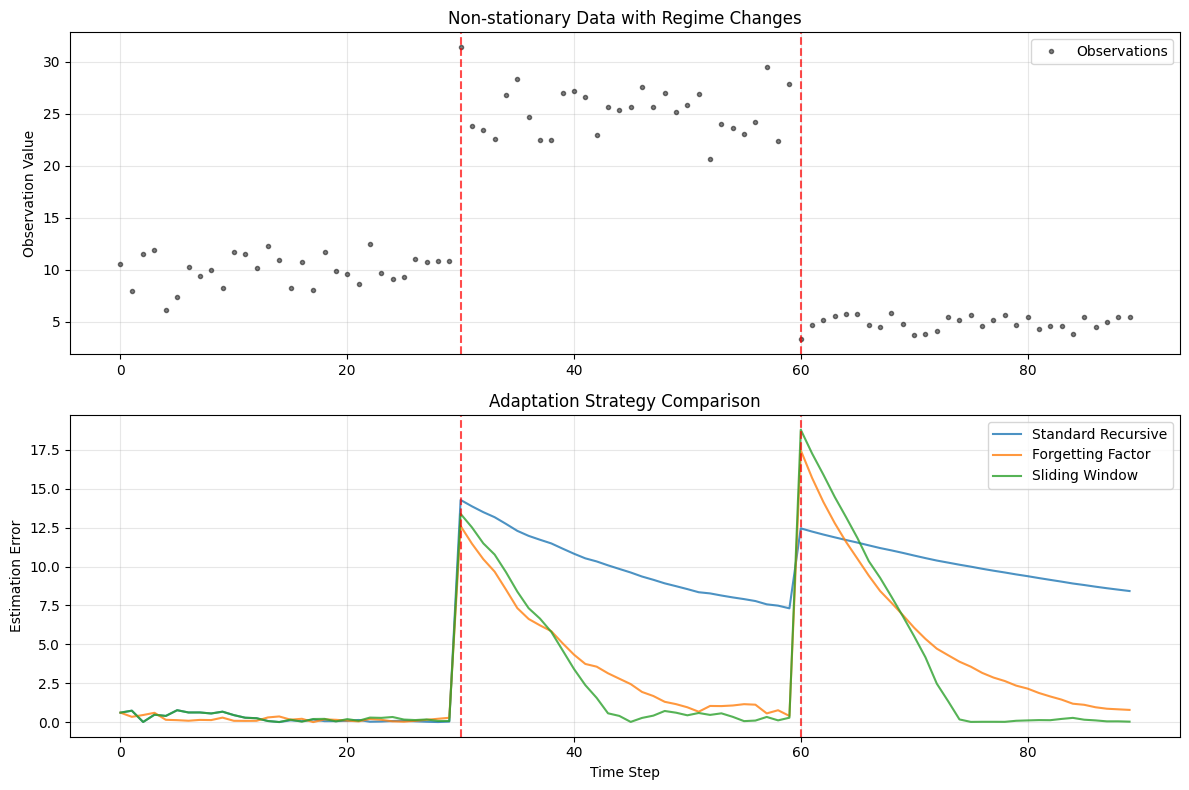


Key insights:
- Standard recursive filtering fails with regime changes
- Forgetting factors help adapt to new regimes
- Sliding windows provide good balance of adaptation and stability
- Choice depends on expected change frequency and noise levels


In [ ]:
#| export
def non_stationary_demo(change_points, segment_patterns, n_observations=100):
    """Demonstrate challenges with non-stationary data"""
    rng = np.random.default_rng(42)
    
    # Generate non-stationary data
    observations = []
    true_states = []
    current_segment = 0
    
    for t in range(n_observations):
        # Check for regime change
        if current_segment < len(change_points) and t >= change_points[current_segment]:
            current_segment += 1
        
        # Generate observation from current pattern
        pattern = segment_patterns[min(current_segment, len(segment_patterns) - 1)]
        obs = rng.normal(pattern['mean'], pattern['std'])
        observations.append(obs)
        true_states.append(current_segment)
    
    return observations, true_states

def compare_adaptation_strategies(observations, true_states, strategies):
    """Compare different adaptation strategies for non-stationary data"""
    results = {name: {'estimates': [], 'errors': []} for name in strategies}
    
    for strategy_name, strategy_fn in strategies.items():
        estimates = strategy_fn(observations)
        errors = [abs(est - true) for est, true in zip(estimates, true_states)]
        
        results[strategy_name]['estimates'] = estimates
        results[strategy_name]['errors'] = errors
        
        print(f"{strategy_name}: Mean error = {np.mean(errors):.3f}")
    
    return results

def forgetting_factor_filter(observations, forgetting_factor=0.95):
    """Simple filter with exponential forgetting"""
    estimates = []
    current_estimate = observations[0] if observations else 0
    
    for obs in observations:
        current_estimate = forgetting_factor * current_estimate + (1 - forgetting_factor) * obs
        estimates.append(current_estimate)
    
    return estimates

def windowed_filter(observations, window_size=20):
    """Simple windowed mean filter"""
    estimates = []
    
    for i, obs in enumerate(observations):
        start_idx = max(0, i - window_size + 1)
        window_data = observations[start_idx:i+1]
        estimates.append(np.mean(window_data))
    
    return estimates

def standard_recursive_filter(observations):
    """Standard recursive mean (no adaptation)"""
    estimates = []
    running_mean = 0
    
    for i, obs in enumerate(observations):
        running_mean = (running_mean * i + obs) / (i + 1)
        estimates.append(running_mean)
    
    return estimates

# Demonstrate non-stationarity challenges
print("=== NON-STATIONARITY CHALLENGES ===")

# Define regime changes
change_points = [30, 60]
segment_patterns = [
    {'mean': 10, 'std': 2},   # Regime 1
    {'mean': 25, 'std': 3},   # Regime 2  
    {'mean': 5, 'std': 1}     # Regime 3
]

obs_data, true_regimes = non_stationary_demo(change_points, segment_patterns, 90)

# Compare adaptation strategies
strategies = {
    'Standard Recursive': standard_recursive_filter,
    'Forgetting Factor': lambda x: forgetting_factor_filter(x, 0.9),
    'Sliding Window': lambda x: windowed_filter(x, 15)
}

adaptation_results = compare_adaptation_strategies(obs_data, [p['mean'] for p in segment_patterns for _ in range(30)], strategies)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Top: Observations and true regime changes
time_steps = np.arange(len(obs_data))
ax1.plot(time_steps, obs_data, 'k.', alpha=0.5, label='Observations')

# Mark regime changes
for cp in change_points:
    ax1.axvline(cp, color='red', linestyle='--', alpha=0.7)

ax1.set_ylabel('Observation Value')
ax1.set_title('Non-stationary Data with Regime Changes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Estimation errors
for strategy_name, strategy_data in adaptation_results.items():
    ax2.plot(time_steps, strategy_data['errors'], label=strategy_name, alpha=0.8)

for cp in change_points:
    ax2.axvline(cp, color='red', linestyle='--', alpha=0.7)

ax2.set_xlabel('Time Step')
ax2.set_ylabel('Estimation Error')
ax2.set_title('Adaptation Strategy Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey insights:")
print("- Standard recursive filtering fails with regime changes")
print("- Forgetting factors help adapt to new regimes")
print("- Sliding windows provide good balance of adaptation and stability")
print("- Choice depends on expected change frequency and noise levels")

## Summary and Key Takeaways

Recursive Bayesian updating transforms static inference into dynamic, adaptive learning:

### **Mathematical Elegance**
- **Recursive structure**: Today's posterior becomes tomorrow's prior
- **Markov property**: Future depends only on present state
- **Optimality**: Mathematically optimal under stationarity assumptions

### **Computational Advantages**
- **Memory efficiency**: O(1) storage vs O(n) for batch processing
- **Real-time capability**: Updates as evidence arrives
- **Scalability**: Performance independent of history length

### **Practical Applications**
- **Threat monitoring**: Adaptive baselines for anomaly detection
- **Attack detection**: Multi-step pattern recognition
- **State tracking**: Object tracking and motion estimation

### **Limitations and Solutions**
- **Non-stationarity**: Use forgetting factors or sliding windows
- **Model mismatch**: Robust estimation techniques
- **Computational complexity**: Approximate methods (particle filters)

### **Integration with Modern AI**
- **Hybrid approaches**: Combine with neural networks
- **Meta-learning**: Learn to adapt adaptation parameters
- **Uncertainty quantification**: Maintain probabilistic reasoning

The recursive nature of Bayesian updating makes it particularly powerful for cybersecurity applications where threats evolve continuously and decisions must be made in real-time with limited computational resources.

In [ ]:
#| export
__all__ = [
    # Core recursive functions
    'recursive_bayes_demo', 'particle_filter', 'markov_chain_demo',
    
    # Interactive components
    'belief_evolution_visualizer', 'recursive_update_component',
    
    # Performance analysis
    'batch_vs_recursive_comparison', 'plot_performance_comparison',
    
    # Memory analysis
    'memory_analysis', 'plot_memory_analysis', 
    
    # Cybersecurity applications
    'adaptive_threat_monitor', 'multi_step_attack_detection',
    
    # Non-stationarity handling
    'non_stationary_demo', 'compare_adaptation_strategies',
    'forgetting_factor_filter', 'windowed_filter', 'standard_recursive_filter'
]